# 1. Data from the Web

In this assignment our goal was to obtain the top 200 universities from two different platforms containing the worldwide global rankings of universities (in particular, www.topuniversities.com and www.timeshighereducation.com) and do the analysis of the obtained datasets. The neccessary information we needed to extract for each university was the name, rank, country and region to which it belongs, number of faculty members (international and total) and number of students (international and total). For the analysis part, we needed to explore rankings of the universities considering different attributes, for example percentage of international students and ratio between faculty members and students. 
As for the structure of the assignment solution we can differentiate a few steps taken in order to get the needed results.
* Getting data from websites
* Analyzing data from each website
* Merging the data obtained from the two websites
* Finding the correlation in data


In [3]:
# Import libraries
import requests
from bs4 import BeautifulSoup

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set_context('notebook')

# 2. Top Universities
## 2.1. Extracting data

We will start with the first site, *www.topuniversities.com*. In order to find the data on a webpage, it is useful to record the network activity and see the request traffic that is produced while loading the website page. To narrow the search even more, we will focus on finding the xhr type of request which stands for XMLHttpRequest whose methods transfer **data** between a web browser and a web server. By searching for this type of request while inspecting the webpage with the rankings of the universities, we have noticed the location from which the data has been taken, so we add that location to our URL path. With this, we are able to get all the data about the university rankings in a json format.

In [50]:
URL = 'https://www.topuniversities.com/'
# get the data on universities using the link we obtained with Postman
r = requests.get(URL + 'sites/default/files/qs-rankings-data/357051.txt?_=1508330840069')
json = r.json()


As this data is available in the json format, it was easy to extract the information needed for the analysis. While going through the first 200 universities, we create a dictionary of universities where each item has name, country and region that the university belongs to. We also keep track of the ranking of the university, but here we notice that rankings in the data weren't labeled as integers, because of having the '=' sign if some universities shared ranks. To fix this, we replace the equals sign and convert ranks to numeric. 

In [5]:
data = json['data']
N = 200;
columns = ['name', 'country', 'region', 
           'faculty members (international)', 'faculty members (total)',
           'students (international)', 'students (total)', 'ratio_members_students', 'ratio_international_students']

ranks = []
universities = []

for i in range(N):
    university = data[i]
    ranks.append(university['rank_display'].replace('=','')) 
    universities.append({'name': university['title'], 
                        'country': university['country'], 
                        'region': university['region']})

df = pd.DataFrame.from_dict(universities)
df.index = pd.to_numeric(ranks)
df = df[columns[:3]]
df.index.name = 'ranking'
df.head(12)

,name,country,region
ranking,,,
1,Massachusetts Institute of Technology (MIT),United States,North America
2,Stanford University,United States,North America
3,Harvard University,United States,North America
4,California Institute of Technology (Caltech),United States,North America
5,University of Cambridge,United Kingdom,Europe
6,University of Oxford,United Kingdom,Europe
7,UCL (University College London),United Kingdom,Europe
8,Imperial College London,United Kingdom,Europe
9,University of Chicago,United States,North America


In [6]:
df.head()

,name,country,region
ranking,,,
1,Massachusetts Institute of Technology (MIT),United States,North America
2,Stanford University,United States,North America
3,Harvard University,United States,North America
4,California Institute of Technology (Caltech),United States,North America
5,University of Cambridge,United Kingdom,Europe


In [7]:
data[11]

{'cc': 'CH',
 'core_id': '177',
 'country': 'Switzerland',
 'guide': '<a href="/where-to-study/europe/switzerland/guide" class="guide-link" target="_blank">Switzerland</a>',
 'logo': '<img src="https://www.topuniversities.com/sites/default/files/ecole-polytechnique-fdrale-de-lausanne-epfl_177_small_1.jpg" alt="Ecole Polytechnique Fédérale de Lausanne (EPFL) Logo">',
 'nid': '294481',
 'rank_display': '12',
 'region': 'Europe',
 'score': '91.2',
 'stars': None,
 'title': 'Ecole Polytechnique Fédérale de Lausanne (EPFL)',
 'url': '/universities/ecole-polytechnique-f%C3%A9d%C3%A9rale-de-lausanne-epfl'}

Now, as we have noticed that some of the needed data for each university isn't available in the first dataset, we need to go a step further and get the infomation for each university in their assigned page, whose URL we can see from the already extracted data. 

In [8]:
universities = []

for i in range(N):
    university = data[i]
    r = requests.get(URL + university['url'])
    soup = BeautifulSoup(r.content, 'html.parser')
    
    try:
        members = int(soup.find(class_='total faculty').find(class_='number').text.strip().replace(',', ''))
        inter_members = int(soup.find(class_='inter faculty').find(class_='number').text.strip().replace(',', ''))    
        students = int(soup.find(class_='total student').find(class_='number').text.strip().replace(',', ''))
        inter_students = int(soup.find(class_='total inter').find(class_='number').text.strip().replace(',', ''))
    except AttributeError:
        members = 'unknown' #maybe np.nan
        inter_members = 'unknown'    
        students = 'unknown'
        inter_students = 'unknown'
    
    
    universities.append({'faculty members (international)': inter_members, 
                        'faculty members (total)': members , 
                        'students (international)': inter_students, 
                        'students (total)': students })



In [9]:
tmp_df = pd.DataFrame.from_dict(universities)
tmp_df.head()


,faculty members (international),faculty members (total),students (international),students (total)
0,1679,2982,3717,11067
1,2042,4285,3611,15878
2,1311,4350,5266,22429
3,350,953,647,2255
4,2278,5490,6699,18770


We will now join these columns to the previosly created dataframe.

In [10]:
df[columns[3:7]] = tmp_df[columns[3:7]]

In [11]:
df[columns[3:7]] = tmp_df[columns[3:7]].values
for col in  df[columns[3:7]]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [12]:
df_top_universities = df[columns[:7]]


## 2.2. Analyzing data
In order to get the information about the ratio between faculty members and students, and the portion of international students, we will add two new columns by dividing the coresponding data. Ratio between members and students is the number of members per each student, and the portion of international students is the ratio between the number of international students per total number of students.

In [13]:
df_top_universities['ratio_members_students'] = round(np.divide(df_top_universities['faculty members (total)'], df_top_universities['students (total)']),2)
df_top_universities['ratio_international_students'] = round(np.divide(df_top_universities['students (international)'], df_top_universities['students (total)']),2)
df_top_universities.head()

,name,country,region,faculty members (international),faculty members (total),students (international),students (total),ratio_members_students,ratio_international_students
ranking,,,,,,,,,
1,Massachusetts Institute of Technology (MIT),United States,North America,1679.0,2982.0,3717.0,11067.0,0.27,0.34
2,Stanford University,United States,North America,2042.0,4285.0,3611.0,15878.0,0.27,0.23
3,Harvard University,United States,North America,1311.0,4350.0,5266.0,22429.0,0.19,0.23
4,California Institute of Technology (Caltech),United States,North America,350.0,953.0,647.0,2255.0,0.42,0.29
5,University of Cambridge,United Kingdom,Europe,2278.0,5490.0,6699.0,18770.0,0.29,0.36


### 2.2.1 Best universities by the ratio between number of members and students

To get the best universites by some attribute, we need to sort the values in dataframe by that attribute. For the case of the ratio between number of members and students, we can observe a difference in rankings from the first dataframe where univiersities are ranked acording to the website and the , as the first university in this order ranked fourth overall, and the difference for the second one is even greater.

In [14]:
df_top_universities.sort_values('ratio_members_students', ascending = False).reset_index()[['ranking','name','ratio_members_students']].head()


,ranking,name,ratio_members_students
0,4,California Institute of Technology (Caltech),0.42
1,16,Yale University,0.40
2,6,University of Oxford,0.34
3,5,University of Cambridge,0.29
4,17,Johns Hopkins University,0.28


We will now plot the obtained data using bar charts. While ploting the observed data, it was interesting to check the connection between rankings of the universities and the ratio they've obtained in the case of faculty members per students. That was shown in the second plot. 

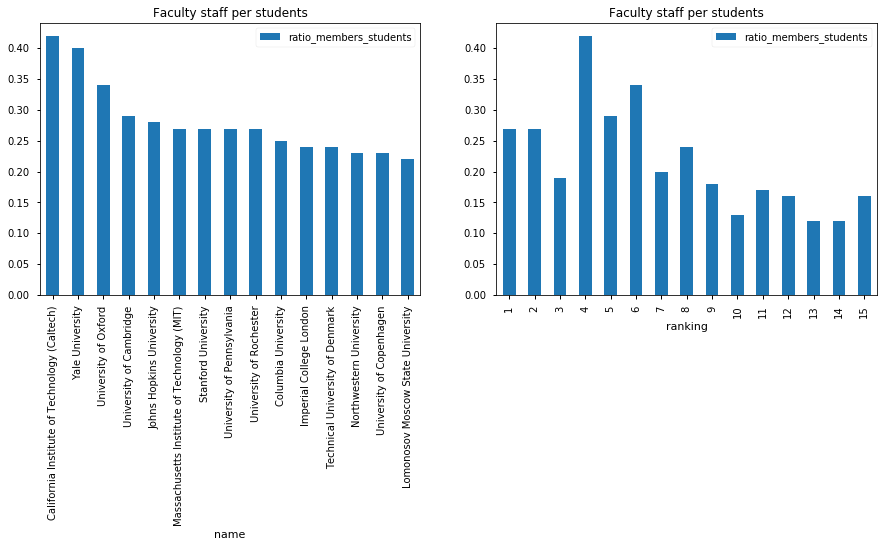

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

df_top_universities.nlargest(n=15,columns=['ratio_members_students']).plot(kind='bar',x='name',y='ratio_members_students',title='Faculty staff per students', ax = ax[0])
df_top_universities.reset_index().nsmallest(n=15,columns=['ranking']).plot(kind='bar',x='ranking',y='ratio_members_students',title='Faculty staff per students', ax = ax[1])


We were expecting some kind of correlation, so we decided to check. 

In [16]:
display(str.format("Correlation coefficient: {}",df_top_universities.reset_index()['ranking'].corr(df_top_universities['ratio_members_students'])))

'Correlation coefficient: -0.40881330225001283'

It turns out that we can conclude some kind of correlation between the two, as the coefficient is a around -0.4. The fact that the value is negative lies in the connection of data. Higher ranked universities, have the higher ratio between faculty members and students and since the higher rankings are described as smaller numbers, hence the negative correlation.  

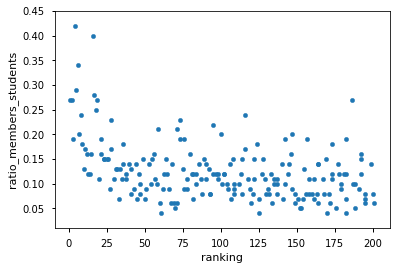

In [17]:
df_top_universities.reset_index().plot(kind='scatter', x='ranking', y='ratio_members_students')


As we wanted to see how the actuall regression line looks like, we have found an option with *Seaborn* package, regplot. Parameters that we needed to include: x, y are input variables, and should be column names in data, in our case, *'ranking'* and *'ratio_members_students'*. Data is the our DataFrame, and with those we can get a plot with regression line.



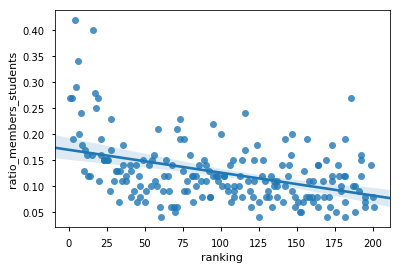

In [18]:
sns.regplot(x='ranking',y='ratio_members_students',data=df_top_universities.reset_index()) 

### 2.2.2 Best universities by the ratio of international students

We then repeated the same procedure, but now regarding the ratio between international and total students. 

In [19]:
df_top_universities.sort_values('ratio_international_students', ascending = False).reset_index()[['name','ratio_international_students']].head()

,name,ratio_international_students
0,London School of Economics and Political Scien...,0.69
1,Ecole Polytechnique Fédérale de Lausanne (EPFL),0.57
2,Imperial College London,0.54
3,Maastricht University,0.50
4,UCL (University College London),0.48


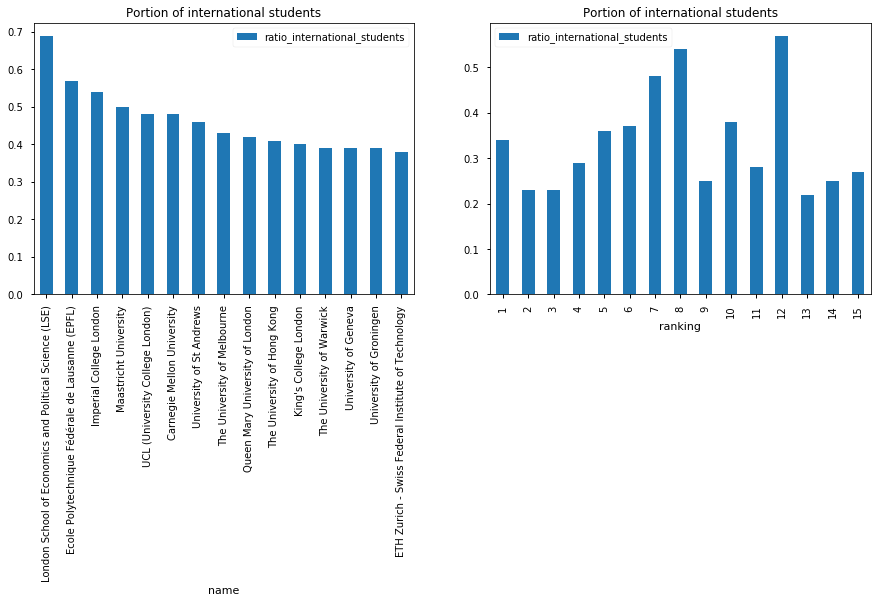

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

df_top_universities.nlargest(n=15,columns=['ratio_international_students']).plot(kind='bar',x='name',y='ratio_international_students',title='Portion of international students',ax=ax[0])
df_top_universities.reset_index().nsmallest(n=15,columns=['ranking']).plot(kind='bar',x='ranking',y='ratio_international_students',title='Portion of international students',ax=ax[1])



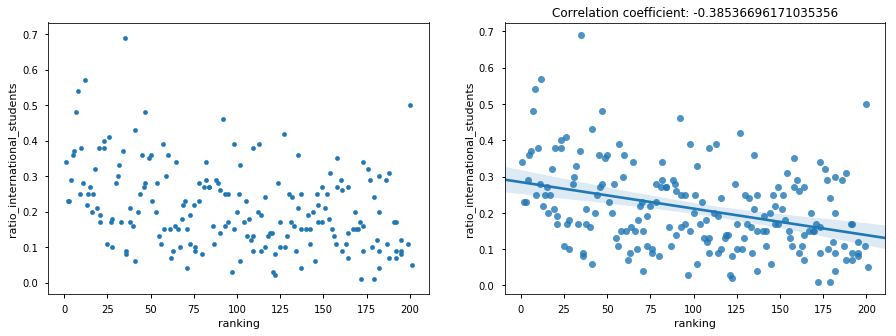

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

corr_coef = df_top_universities.reset_index()['ranking'].corr(df_top_universities['ratio_international_students'])
df_top_universities.reset_index().plot(kind='scatter', x='ranking', y='ratio_international_students',ax = ax[0])
sns.regplot(x='ranking',y='ratio_international_students',data=df_top_universities.reset_index(),ax=ax[1]).set_title(str.format("Correlation coefficient: {}",corr_coef)) 




We can conclude that both ratios are similarly correlated to rankings of universites. 

### 2.2.3 Best countries by the number of universities

Regarding the countries and universites, it was explained that for the assignment we should rank the countries in terms of the number of their national universities in the top 200. In order to give that kind of results, we needed to group data by countries, and count the number of universities, then sort the obtained values. 

,country,count
33,United States,47
32,United Kingdom,28
11,Germany,11
20,Netherlands,10
1,Australia,9


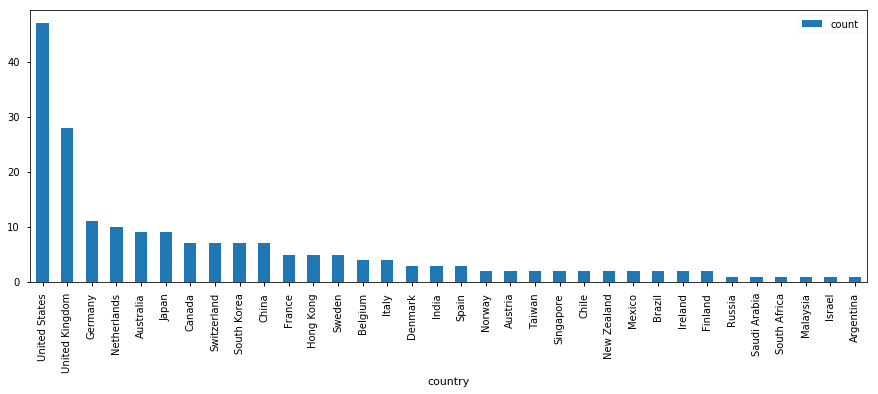

In [22]:
grouped = df_top_universities.groupby('country')['name'].count().reset_index(name='count').sort_values('count', ascending = False)

display(grouped.head())

grouped.plot(kind = 'bar', x='country', figsize=(15,5))


### 2.2.4 Best regions by the number of universities

In the case of regions, we follow the same procedure as with the countries. 

,index,region,count
0,2,Europe,89
1,4,North America,54
2,1,Asia,38
3,5,Oceania,11
4,3,Latin America,7
5,0,Africa,1


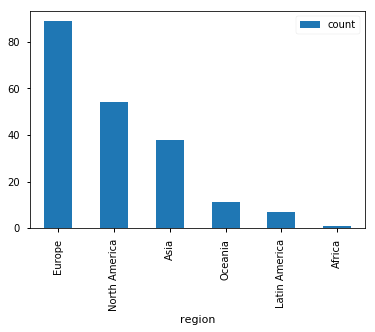

In [23]:
grouped = df_top_universities.groupby('region')['name'].count().reset_index(name='count').sort_values('count', ascending = False)
display(grouped.reset_index().head(10))

grouped.plot(kind = 'bar', x='region')


# 3. Times Higher Education
## 3.1 Extracting data

Now, we will extract the data and repeat the analysis for the second website: https://www.timeshighereducation.com/.


In [24]:
URL = 'https://www.timeshighereducation.com/'
# get the data on universities using the link we obtained with Postman
r = requests.get(URL + 'sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json/')
json = r.json()


Since, the data is diferently structured, we already have all the information we need for the universities inside the json data. This site, however doesn't have the data about the number of international staff members, but we don't need it for this exercise.

In [25]:
data = json['data']
N = 200;
columns = ['name', 'country', 'region',
           'faculty members (total)',
           'students (international)', 'students (total)', 'ratio_members_students', 'ratio_international_students']

ranks = []
universities = []
for i in range(N):
    university = data[i]
    
    students_per_staff = float(university['stats_student_staff_ratio'])
    students_total = int(university['stats_number_students'].replace(',',''))
    percentage_of_int_students = int(university['stats_pc_intl_students'].replace('%',''))
    
    ranks.append(university['rank'].replace('=','')) 
    universities.append({'name': university['name'], 
                         'country': university['location'],
                         'region': np.nan,
                         'faculty members (total)': int(students_total/students_per_staff),
                         'students (international)': int(students_total*percentage_of_int_students/100),
                         'students (total)': students_total,
                         'ratio_members_students': round(1/students_per_staff,2),
                         'ratio_international_students': percentage_of_int_students/100
                         
                        })
df = pd.DataFrame.from_dict(universities)
df.index = pd.to_numeric(ranks)
df_times_higher_education = df[columns[:8]]
df_times_higher_education.index.name = 'ranking'
df_times_higher_education.head()


,name,country,region,faculty members (total),students (international),students (total),ratio_members_students,ratio_international_students
ranking,,,,,,,,
1,University of Oxford,United Kingdom,NaN,1822,7755,20409,0.09,0.38
2,University of Cambridge,United Kingdom,NaN,1687,6436,18389,0.09,0.35
3,California Institute of Technology,United States,NaN,339,596,2209,0.15,0.27
3,Stanford University,United States,NaN,2112,3485,15845,0.13,0.22
5,Massachusetts Institute of Technology,United States,NaN,1284,3800,11177,0.11,0.34


### 3.1.1 Mapping regions
In the data from the second website, we don't have information about the regions to which every university belongs. But this can be extracted from the data in the first dataframe, based on the mapping between countries and regions. To do so, we create *country_to_region* dictionary, which containes keys as country names and the values are regions. We created this dictionary from the groupby object, where we discovered unique pairs of countries and regions. The dictionary can then be applied to a map function, which updates the regions for which the country is in the keys of our previosly created dictionary. 

In [26]:
region_mapping = df_top_universities.groupby(['country', 'region']).count().reset_index()[['country','region']]
display(region_mapping.head())
country_to_region = region_mapping.set_index('country').to_dict()['region']
df_times_higher_education['region'].update(df_times_higher_education['country'].map(country_to_region))
df_times_higher_education.head()

,country,region
0,Argentina,Latin America
1,Australia,Oceania
2,Austria,Europe
3,Belgium,Europe
4,Brazil,Latin America


,name,country,region,faculty members (total),students (international),students (total),ratio_members_students,ratio_international_students
ranking,,,,,,,,
1,University of Oxford,United Kingdom,Europe,1822,7755,20409,0.09,0.38
2,University of Cambridge,United Kingdom,Europe,1687,6436,18389,0.09,0.35
3,California Institute of Technology,United States,North America,339,596,2209,0.15,0.27
3,Stanford University,United States,North America,2112,3485,15845,0.13,0.22
5,Massachusetts Institute of Technology,United States,North America,1284,3800,11177,0.11,0.34


In [27]:
df_times_higher_education['region'].isnull().sum()

2

In [28]:
display(df_times_higher_education.loc[df_times_higher_education['region'].isnull()])

,name,country,region,faculty members (total),students (international),students (total),ratio_members_students,ratio_international_students
ranking,,,,,,,,
179,University of Luxembourg,Luxembourg,NaN,340,2832,4969,0.07,0.57
194,Lomonosov Moscow State University,Russian Federation,NaN,4004,6431,29236,0.14,0.22


Here we can see that two more countries need to be mapped to a certain region. This has happened because of the different spelling of certain contries like Russia, or in the case of Luxembourg, because there weren't any universities from this country in the first dataframe.

Now, we are just going to manually map these countries to regions. With the checking for null values in *region* column, we can conclude that there are no more countries needed to be mapped. 

In [29]:
df_times_higher_education['region'].replace(np.nan, 'Europe', inplace=True)
df_times_higher_education['region'].isnull().sum()

0

In [30]:
df_times_higher_education.head()


,name,country,region,faculty members (total),students (international),students (total),ratio_members_students,ratio_international_students
ranking,,,,,,,,
1,University of Oxford,United Kingdom,Europe,1822,7755,20409,0.09,0.38
2,University of Cambridge,United Kingdom,Europe,1687,6436,18389,0.09,0.35
3,California Institute of Technology,United States,North America,339,596,2209,0.15,0.27
3,Stanford University,United States,North America,2112,3485,15845,0.13,0.22
5,Massachusetts Institute of Technology,United States,North America,1284,3800,11177,0.11,0.34


## 3.2 Analyzing data

We can now go on to analyzing the data from the https://www.timeshighereducation.com/ website.

### 3.2.1 Best universities by the ratio between number of members and students


In [31]:
df_times_higher_education.sort_values('ratio_members_students', ascending = False)[columns[0:1]+columns[7:8]].head()
#instead of writing names of all the columns we want to show, we can use our list of columns defined in the previous part of the assignment


,name,ratio_international_students
ranking,,
105,Vanderbilt University,0.13
109,University of Copenhagen,0.14
13,Johns Hopkins University,0.24
153,University of Rochester,0.29
98,Emory University,0.19


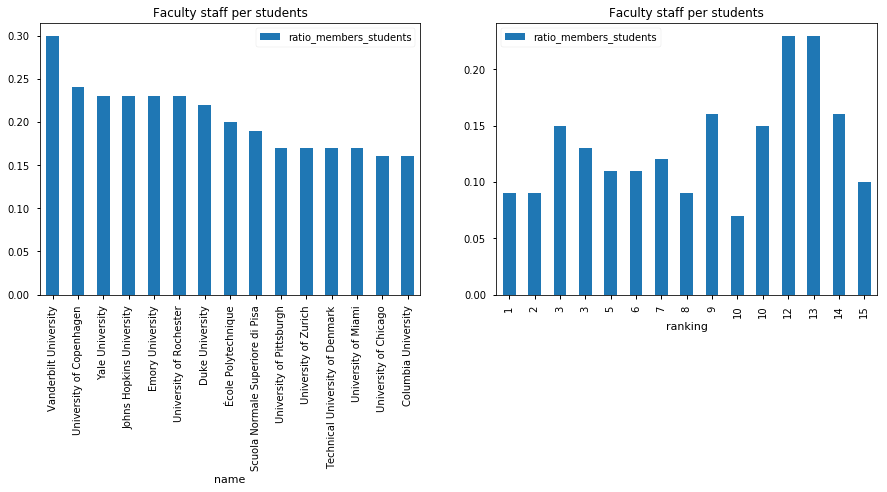

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

df_times_higher_education.nlargest(n=15,columns=['ratio_members_students']).plot(kind='bar',x='name',y='ratio_members_students',title='Faculty staff per students',ax=ax[0])
df_times_higher_education.reset_index().nsmallest(n=15,columns=['ranking']).plot(kind='bar',x='ranking',y='ratio_members_students',title='Faculty staff per students', ax=ax[1])


In the second site however, the data between rankings and ratio of faculty members isn't correlated. We conclude that based on the correlation coefficint that is around 0.15.

'Correlation coefficient: -0.1469353669279357'

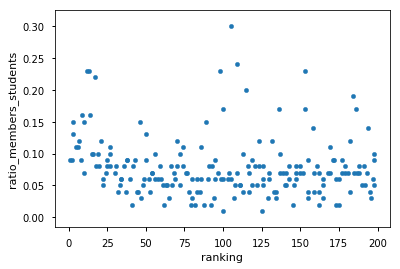

In [33]:
display(str.format("Correlation coefficient: {}", df_times_higher_education.reset_index()['ranking'].corr(df_times_higher_education['ratio_members_students'])))
df_times_higher_education.reset_index().plot(kind='scatter', x='ranking', y='ratio_members_students')


### 3.2.2 Best universities by the ratio of international students


In [34]:
df_times_higher_education.sort_values('ratio_international_students', ascending = False)[columns[0:1]+columns[8:9]].reset_index().head()


,ranking,name
0,25,London School of Economics and Political Science
1,179,University of Luxembourg
2,38,École Polytechnique Fédérale de Lausanne
3,8,Imperial College London
4,103,Maastricht University


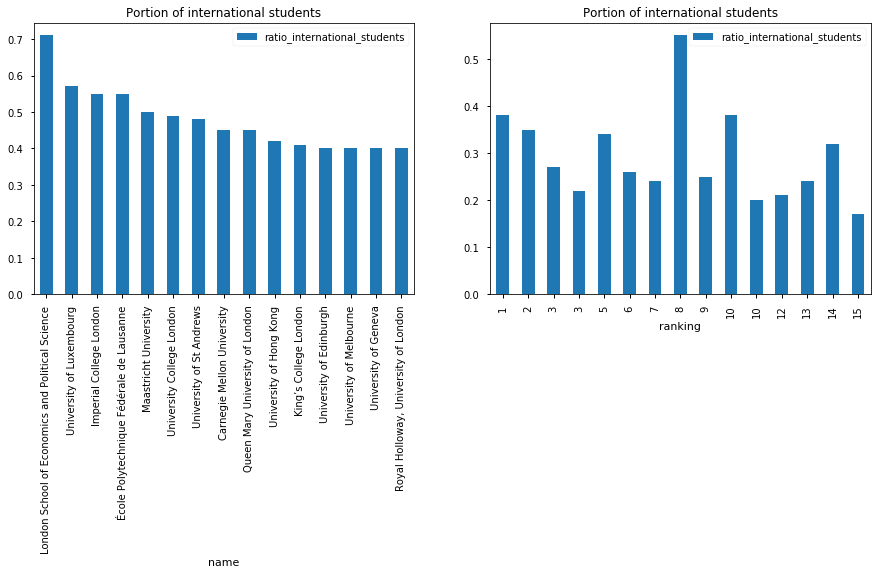

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

df_times_higher_education.nlargest(n=15,columns=['ratio_international_students']).plot(kind='bar',x='name',y='ratio_international_students',title='Portion of international students',ax=ax[0])
df_times_higher_education.reset_index().nsmallest(n=15,columns=['ranking']).plot(kind='bar',x='ranking',y='ratio_international_students',title='Portion of international students',ax=ax[1])


The coefficinet is somewhat better in the case of international students, but still, it doesn't say much about the correlation between rankings and portion of international students. We can conclude that this site doesn't take into account this attribute, unlike the first site. 

'Correlation coefficient: -0.21409243878710757'

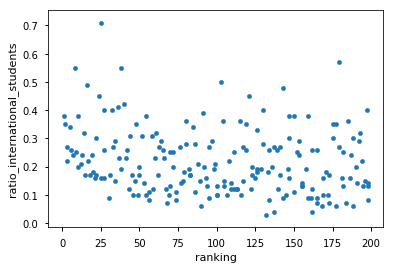

In [36]:
display(str.format("Correlation coefficient: {}", df_times_higher_education.reset_index()['ranking'].corr(df_times_higher_education['ratio_international_students'])))
df_times_higher_education.reset_index().plot(kind='scatter', x='ranking', y='ratio_international_students')


### 3.2.3 Best countries by the number of universities


,country,count
26,United States,62
25,United Kingdom,31
8,Germany,20
14,Netherlands,13
0,Australia,8


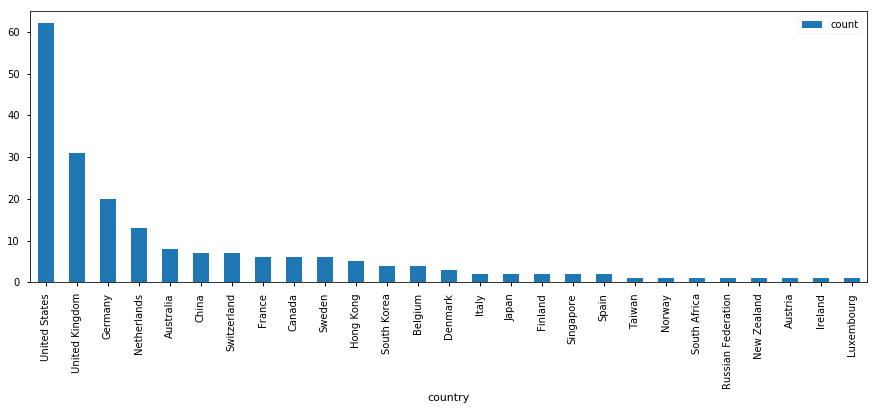

In [37]:
grouped = df_times_higher_education.groupby('country')['name'].count().reset_index(name='count').sort_values('count', ascending = False)

display(grouped.head())

grouped.plot(kind = 'bar', x='country', figsize=(15,5))


### 3.2.4 Best regions by the number of universities


,index,region,count
0,2,Europe,101
1,3,North America,68
2,1,Asia,21
3,4,Oceania,9
4,0,Africa,1


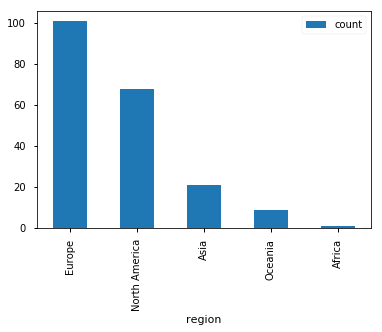

In [38]:
grouped = df_times_higher_education.groupby('region')['name'].count().reset_index(name='count').sort_values('count', ascending = False)
display(grouped.reset_index().head())

grouped.plot(kind = 'bar', x='region')


Since we have noticed a difference in some key attributes of data regarding the two websites, we proceded to visualizing the differences regarding the number of universities in top 200 by country and region. We can see that the TimesHigherEducation website has greater number of universities that come from United States, United Kingdom and Germany in compare to TopUniversities. This is why we can also observe that number of universities from Asia in TopUniversities is greatly higher compared to TimesHigherEducation.

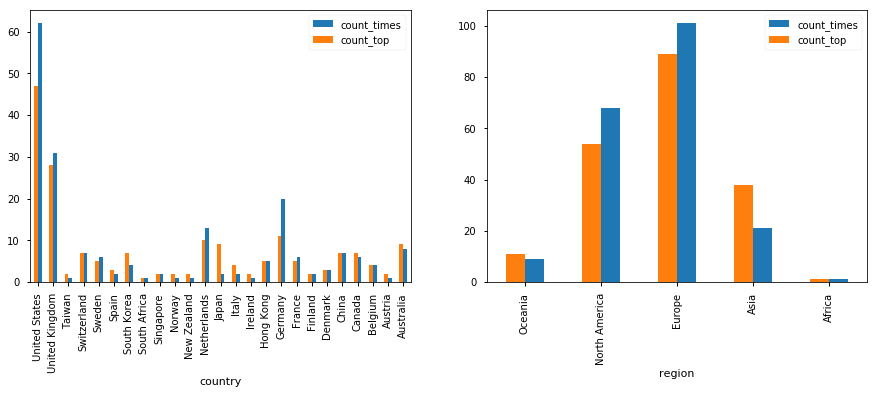

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

grouped_times_country = df_times_higher_education.groupby('country')['name'].count().reset_index(name='count')
grouped_top_country = df_top_universities.groupby('country')['name'].count().reset_index(name='count')

merged_by_country = grouped_times_country.merge(grouped_top_country,on='country', how='inner', suffixes = ['_times','_top'])
merged_by_country.plot(kind='bar', x='country', y=['count_times','count_top'], ax=ax[0]).invert_xaxis()

grouped_times_region = df_times_higher_education.groupby('region')['name'].count().reset_index(name='count')
grouped_top_region = df_top_universities.groupby('region')['name'].count().reset_index(name='count')

merged_by_region = grouped_times_region.merge(grouped_top_region, on='region', how='inner', suffixes = ['_times','_top'])
merged_by_region.plot(kind='bar', x='region', y=['count_times','count_top'], ax=ax[1]).invert_xaxis()

## 4. Merging Data

We will now go on to merging two dataframes. The problems that can occur come from the fact that same universities are labeled differently in both datasets. We can overcome this problem using some key operations on names of the universites. 

* We can delete the accents using the unidecodedata python module.
* We can transform the names to lowecase
* We can search for the matching only within universities from the same country
* We can exclude the 'university', 'institute', 'college', parts, but we should be careful for if we exclude all there will be less information in names to differentiate universities so we might get wrong matches as a result. 
* We can remove the ajdective 'of' and the word 'the'.

Between names defined as previosly explained, we will use the function that checks for similarity of string names from the external library difflib. 

Using the function *get_close_matches*, we were able to retrieve the optimal translations between the names in both dataset. This has also given us an option to set *np.nan* values for universities that are not mutual for both datasets.

The function **difflib.get_close_matches(word, possibilities[, n][, cutoff])** returns a list of the best “good enough” matches. Word is in our case the name of the university from one dataframe for which close matches are desired. Possibilities is a list of the names of universities from the same country the first university is from, but from the second dataframe *(column in the second dataframe with the label 'name')* against which we want to match the name in first dataframe. 

Optional argument n (default 3) is the maximum number of close matches to return; n must be greater than 0.

Optional argument cutoff (default 0.6) is a float in the range [0, 1]. Possibilities that don’t score at least that similar to word are ignored. We tested several values for this argument and conclued that the optimal cutoff should be 0.6, because it gives the best results regarding the number of correctly matched names and correctly defined *np.nan* values for non mutual universities. 

The best (no more than n) matches among the possibilities are returned in a list, sorted by similarity score, most similar first.



In [40]:
times_higher_education = df_times_higher_education.copy()
top_universities = df_top_universities.copy()


Since our method would be using the names of universities based on the country we want to make sure that the two dataframes have same names for countries. As we have seen earlier, Russia is labeled as Russian Federation in TimesHigherEducation so we want to change that. 

In [41]:
times_higher_education['country'].replace('Russian Federation', 'Russia', inplace=True)


In [42]:
import difflib
import unicodedata
def fuzzy_match(uni_name, df_compare_from, df_compare_to):    
    country = df_compare_from.loc[df_compare_from['name'] == uni_name]['country'].tolist()[0]
    '''
    we are tranfroming the university name as explained in the intro (removing accents, lowering case...)
    ''' 
    left = 'unknown' if pd.isnull(uni_name) else unicodedata.normalize('NFKD', uni_name).encode('ASCII', 'ignore').decode("utf-8").lower().replace('munchen','munich').replace('university','').replace('the','').replace('of','').replace('college','').replace('institute','')
    '''
    we want to save the original name of the university in a dictionary so that we can return that value, and not the 
    one used for calculations 
    '''
    maping_names={}
    universities_from_same_country = df_compare_to.loc[df_compare_to['country'] == country]['name'].tolist()
    for university in universities_from_same_country:
        new_name = unicodedata.normalize('NFKD', university).encode('ASCII', 'ignore').decode("utf-8").lower().replace('munchen','munich').replace('university','').replace('the','').replace('of','').replace('college','').replace('institute','')        
        maping_names[new_name] = university
 
    right = maping_names.keys()
    out = difflib.get_close_matches(left, right, cutoff=0.6)
    return maping_names[out[0]] if out else np.NaN
    
    
times_higher_education['new_name'] = times_higher_education['name'].map(lambda x: fuzzy_match(x,times_higher_education,top_universities))

display(times_higher_education[['name','new_name']].head())



,name,new_name
ranking,,
1,University of Oxford,University of Oxford
2,University of Cambridge,University of Cambridge
3,California Institute of Technology,California Institute of Technology (Caltech)
3,Stanford University,Stanford University
5,Massachusetts Institute of Technology,Massachusetts Institute of Technology (MIT)


After applying the matching function *(fuzzy_match)* to dataframes, there was some incorrectly labeled data that needed to be manually fixed. Looking through the new names of universities, we have noticed the ones that needed to be manually updated, so we proceded to doing so. 

In [43]:

times_higher_education.loc[times_higher_education['name'] == 'LMU Munich','new_name'] = 'Ludwig-Maximilians-Universität München'
times_higher_education.loc[times_higher_education['name'] == 'Heidelberg University','new_name'] = 'Ruprecht-Karls-Universität Heidelberg'
times_higher_education.loc[times_higher_education['name'] == 'University of Freiburg','new_name'] = 'Albert-Ludwigs-Universitaet Freiburg'
times_higher_education.loc[times_higher_education['name'] == 'Technical University of Berlin','new_name'] = 'Technische Universität Berlin (TU Berlin)'
times_higher_education.loc[times_higher_education['name'] == 'University of Tübingen','new_name']='Eberhard Karls Universität Tübingen'
times_higher_education.loc[times_higher_education['name'] == 'Arizona State University','new_name'] = np.nan
times_higher_education.loc[times_higher_education['name'] == 'Charité - Universitätsmedizin Berlin','new_name'] = np.nan
times_higher_education.loc[times_higher_education['name'] == 'University of Leicester','new_name'] = np.nan


In [44]:
times_higher_education['name'] = times_higher_education['new_name']
times_higher_education.drop('new_name', axis=1, inplace=True)

After labeling the data correctly, we merged the two dataframes using the 'inner' property of the merge function, so we would get rid of all the rows containing *np.nan* values, as those represent universities that are present in the ranking on one website, but not in the other. We also set the left_on and right_on labels to *['name','country','region']* so that we would have a dataframe with unique combinations of those three columns.

In [45]:
merged = top_universities.reset_index().merge(times_higher_education.reset_index(),left_on=['name','country','region'],right_on=['name','country','region'], how='inner', suffixes=['_top','_times'])
merged.set_index(['name','country','region'], inplace=True)
merged.head()


,,,ranking_top,faculty members (international),faculty members (total)_top,students (international)_top,students (total)_top,ratio_members_students_top,ratio_international_students_top,ranking_times,faculty members (total)_times,students (international)_times,students (total)_times,ratio_members_students_times,ratio_international_students_times
name,country,region,,,,,,,,,,,,,
Massachusetts Institute of Technology (MIT),United States,North America,1,1679.0,2982.0,3717.0,11067.0,0.27,0.34,5,1284,3800,11177,0.11,0.34
Stanford University,United States,North America,2,2042.0,4285.0,3611.0,15878.0,0.27,0.23,3,2112,3485,15845,0.13,0.22
Harvard University,United States,North America,3,1311.0,4350.0,5266.0,22429.0,0.19,0.23,6,2283,5284,20326,0.11,0.26
California Institute of Technology (Caltech),United States,North America,4,350.0,953.0,647.0,2255.0,0.42,0.29,3,339,596,2209,0.15,0.27
University of Cambridge,United Kingdom,Europe,5,2278.0,5490.0,6699.0,18770.0,0.29,0.36,2,1687,6436,18389,0.09,0.35


# 5. Exploratory Analysis

For the universities in the final merged dataframe, we did some exploratory analysis. 

First, we wanted to see if the total number of students and number of international students are dependant on the rank both in TopUniversites and TimesHigherEducation. 

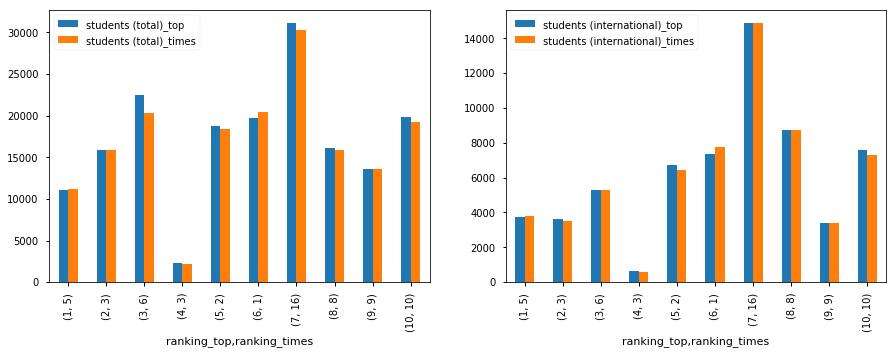

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

merged.nsmallest(n=10,columns=['ranking_top','ranking_times']).plot(kind='bar',x=['ranking_top','ranking_times'],y=['students (total)_top','students (total)_times'], ax=ax[0])
merged.nsmallest(n=10,columns=['ranking_top','ranking_times']).plot(kind='bar',x=['ranking_top','ranking_times'],y=['students (international)_top','students (international)_times'], ax=ax[1])


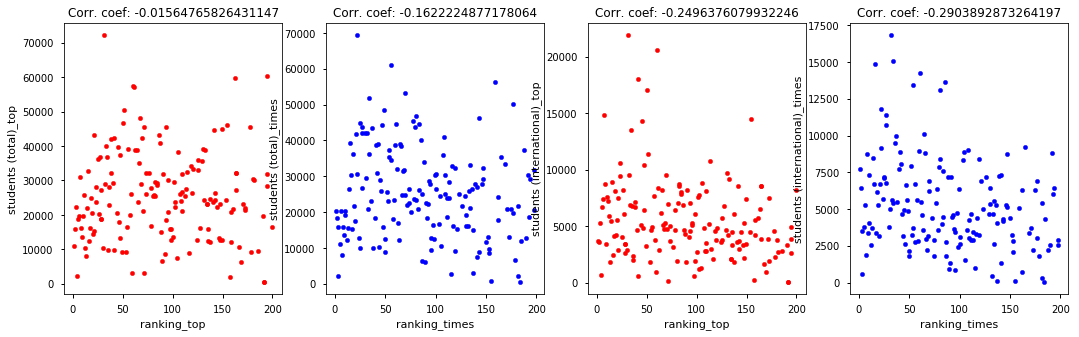

In [47]:
fig, ax = plt.subplots(1, 4, figsize=(18,5))

coef_ranking_students_total_top = merged['ranking_top'].corr(merged['students (total)_top'])
coef_ranking_students_total_times = merged['ranking_times'].corr(merged['students (total)_times'])
coef_ranking_students_international_top = merged['ranking_top'].corr(merged['students (international)_top'])
coef_ranking_students_international_times = merged['ranking_times'].corr(merged['students (international)_times'])

merged.plot(kind='scatter', x='ranking_top', y='students (total)_top', color='r',ax=ax[0], title= str.format('Corr. coef: {}',coef_ranking_students_total_top))
merged.plot(kind='scatter', x='ranking_times', y='students (total)_times', color='b', ax=ax[1], title = str.format('Corr. coef: {}', coef_ranking_students_total_times))   
merged.plot(kind='scatter', x='ranking_top', y='students (international)_top', color='r',ax=ax[2], title = str.format('Corr. coef: {}',coef_ranking_students_international_top))
merged.plot(kind='scatter', x='ranking_times', y='students (international)_times', color='b', ax=ax[3], title = str.format('Corr. coef: {}', coef_ranking_students_international_times))   


We observe the greatest correlation between the rankings of university in TimesHigherEducation site and the number of international students. Again, the coefficient is negative as explained earlier, but this is still not a strong correlation, so we will continue exploring data. 

#### 1. plot - faculty members (international) : students (international)
Looking forward to find a stronger correlation in data, we tested if the number of students (international) is dependant on faculty members (international). We could only do this for the TopUniversities dataset, as the second site didn't have the information about the number of international faculty members.
#### 2. plot - faculty members (total) : students (total) for TopUniversities
For the second plot, we wanted to see how the number of students is correlated with number of faculty members. We expected higher values of correlation coefficient for this case. 
#### 3. plot - faculty members (total) : students (total) for TimesHigherEducation
This plot shows the same relation but for the TimesHigherEducation website. As seen earlier, the data is a bit different so the value for the correlation coefficinet proves this fact. 
#### 4. plot - students (international) : students (total) for TopUniversities
For the relation between the number of international students and total number of students, we expected the higher valued correlation coefficient, and indeed, our intuition was right. 


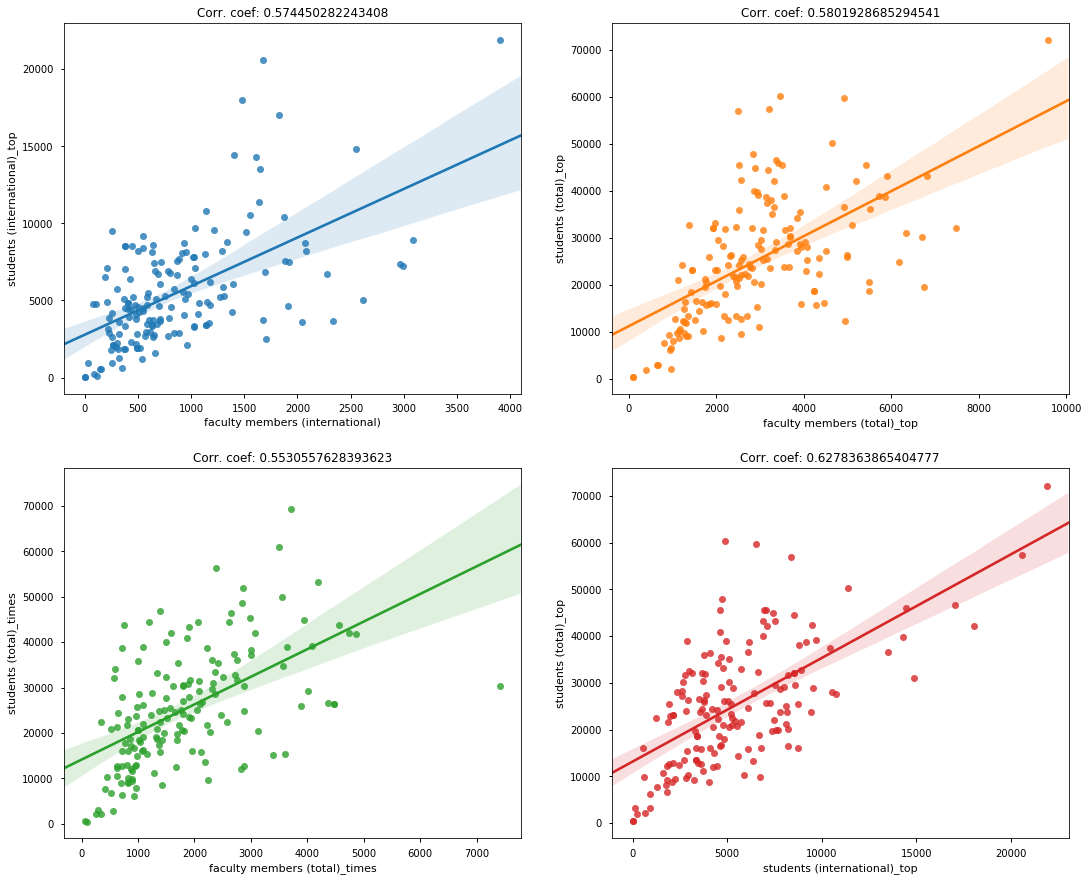

In [84]:
fig, ax = plt.subplots(2, 2, figsize=(18,15))

coef_members_international_students_international_top = merged['faculty members (international)'].corr(merged['students (international)_top'])
coef_members_students_top = merged['faculty members (total)_top'].corr(merged['students (total)_top'])
coef_members_students_times = merged['faculty members (total)_times'].corr(merged['students (total)_times'])
coef_students_international_students_total_top = merged['students (international)_top'].corr(merged['students (total)_top'])
coef_students_international_students_total_times = merged['students (international)_times'].corr(merged['students (total)_times'])

sns.regplot(x='faculty members (international)', y='students (international)_top', data = merged, ax=ax[0,0]).set_title(str.format('Corr. coef: {}',coef_members_international_students_international_top))

sns.regplot(x='faculty members (total)_top', y='students (total)_top', data=merged, ax=ax[0,1]).set_title(str.format('Corr. coef: {}', coef_members_students_top))   
sns.regplot(x='faculty members (total)_times', y='students (total)_times', data=merged, ax=ax[1,0]).set_title(str.format('Corr. coef: {}', coef_members_students_times))   

sns.regplot(x='students (international)_top', y='students (total)_top',data=merged, ax=ax[1,1]).set_title(str.format('Corr. coef: {}',coef_students_international_students_total_top))



Most of these correlations make sense. We expect indeed the number of international students to be proportional to the number of international faculty members or the number of total students to be proportional to the total number of faculty members. We plotted the correlations for data from both Times Higher Education and TopUniversities and the same trends can be observed even though there are small differences in the data they provide.

It was interesting to see, however, that the number of international faculty members can be correlated to the number of international students. Maybe the number of international stall is percieved as an opportunity for the students to have a professional career at the university or maybe these faculty members have some kind of influence (lectures, internship offers...) on students in their originated countries to enroll at that particular university.

# 6. Best University

In order to give the final ranking to universities and find the best one, we took in consideration several key points. 
The first idea that comes to mind is to take the average of rankings based on the two websites and create a final ranking using the data created in that way. Other kind of means, like the geometric or the harmonic ones could be considered.

But, as we have already observed, the data in the TimesHigherEducation has a slight bias to universities in North America and Europe, especially the countries of United States, United Kingdom and Germany. We have observed a great difference in number of universities from these countries and beside that we haven't fount the correlation between the calculated ratios and rankings from the second website. That's why we can take the data gathered from that website with a little caution.

Thus, an idea could be to take a weighted average, with a lower coefficient for the Times Higher Education ranking. However, that approach gives more importance to one of the rankings which is unfair because what seems to be biaised in Times Higher Education ranking could in fact just reflect the reality.

The ratios of international students and faculty members per student could be used to make a ranking but these ones don't seem very relevant when it comes to the competitivity and the performance of the universities. Moreover they are already taken in consideration in both rankings, so counting them would result in abundance of the same measurements. 

We chose to calculate the min and max rank of each university and to take a weighted average where the max rank has a higher weight. In this way, universities which are ranked well in one of the rankings but which have a lower rank in the other one are penalized.

In [87]:
ranking_df = merged[['ranking_top','ranking_times']]

ranking_df['max'] = ranking_df[['ranking_top', 'ranking_times']].max(axis=1)
ranking_df['min'] = ranking_df[['ranking_top', 'ranking_times']].min(axis=1)

#Arithmetic mean
ranking_df['arithmetic'] = ranking_df[['ranking_top', 'ranking_times']].mean(axis=1)
#Geometric mean
ranking_df['geometric'] = ranking_df.apply(lambda x: np.sqrt(x['ranking_top']*x['ranking_times']), axis=1)
#Harmonic mean
ranking_df['harmonic'] = ranking_df.apply(lambda x: np.sqrt(x['geometric']*x['geometric']/x['arithmetic']), axis=1)
#Linear combinaison of the min and the max

ranking_df['LCminmax'] = 0.3*ranking_df['min'] + 0.7*ranking_df['max']

ranking_df.sort_values('LCminmax').head(15)

,,,ranking_top,ranking_times,max,min,arithmetic,geometric,harmonic,LCminmax
name,country,region,,,,,,,,
Stanford University,United States,North America,2,3,3,2,2.5,2.449490,1.549193,2.7
California Institute of Technology (Caltech),United States,North America,4,3,4,3,3.5,3.464102,1.851640,3.7
Massachusetts Institute of Technology (MIT),United States,North America,1,5,5,1,3.0,2.236068,1.290994,3.8
University of Cambridge,United Kingdom,Europe,5,2,5,2,3.5,3.162278,1.690309,4.1
University of Oxford,United Kingdom,Europe,6,1,6,1,3.5,2.449490,1.309307,4.5
Harvard University,United States,North America,3,6,6,3,4.5,4.242641,2.000000,5.1
Imperial College London,United Kingdom,Europe,8,8,8,8,8.0,8.000000,2.828427,8.0
University of Chicago,United States,North America,9,9,9,9,9.0,9.000000,3.000000,9.0
ETH Zurich - Swiss Federal Institute of Technology,Switzerland,Europe,10,10,10,10,10.0,10.000000,3.162278,10.0


In [88]:
ranking_df['final_rank'] = ranking_df['LCminmax'].rank(method='min').astype(int)
display(ranking_df.reset_index().sort_values(['final_rank'])[['name','final_rank']].head(1))

,name,final_rank
1,Stanford University,1


In most of the generated functions for ranking the universities, Stanford almost always managed to stay on the top, so we can agree to rank this university as the best one.